<div align=center><img src = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/IDSNlogo.png" width = 300 > 

# This ipynb file was developed on Skills Network Labs 
## Background: I'm looking to open a Chinese restaurant in Toronto. I want to use below features to decide where to open it.
### Features: location, population, popularity of Chinese restaurant, income, proportion of Chinese, competitor, crime rate and so on.


install and import necessary libraries

In [2]:
'''
!pip install bs4
!pip install geopy
!pip install descartes
!pip install folium
!pip install shapefile
!pip install pyviz holoviz geoviews
!pip install pyshp
!pip install yellowbrick
!pip install geopandas
'''
import numpy as np 
import pandas as pd
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import descartes
import matplotlib.pyplot as plt
import folium
import shapefile as shp
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets import make_blobs
import matplotlib.cm as cm
import matplotlib.colors as colors

## Download Toronto neighborhood profile data from CKAN Organisations-Toronto

In [58]:
import io
nei_profile = pd.read_csv('https://ckan0.cf.opendata.inter.prod-toronto.ca/en_AU/datastore/dump/ef0239b1-832b-4d0b-a1f3-4153e53b189e')
nei_profile.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


## I downloaded Toronto crime rate data and shape file from Toronto Police Service Public Safety Data Portal and uploaded it to GitHub and Skills Network Labs folder.
Load File from GitHub.

In [59]:
nei_crime = pd.read_csv('https://raw.githubusercontent.com/shenwl1014/IBM-Data-Science-Capstone-Project/main/Neighbourhood_Crime_Rates_2020.csv')
nei_crime.head()

,OBJECTID,Neighbourhood,Hood_ID,F2020_Population_Projection,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,...,Shootings_2020,Shooting_Rate2014,Shootings_Rate2015,Shootings_Rate2016,Shootings_Rate2017,Shootings_Rate2018,Shootings_Rate2019,Shootings_Rate2020,Shape__Area,Shape__Length
0,1,Yonge-St.Clair,97,14083,16,25,34,25,28,35,...,0,0.000000,0.000000,7.722008,0.000000,0.000000,0.000000,0.000000,1.161315e+06,5873.270507
1,2,York University Heights,27,30277,273,298,363,351,362,382,...,12,6.963789,0.000000,13.986990,34.504170,27.189610,20.102520,39.634040,1.324666e+07,18504.777616
2,3,Lansing-Westgate,38,18146,42,81,67,84,68,70,...,1,0.000000,0.000000,5.980146,0.000000,5.737564,11.245430,5.510856,5.346186e+06,11112.109419
3,4,Yorkdale-Glen Park,31,17560,106,137,175,163,178,210,...,14,19.740740,19.752440,19.700550,44.312210,61.042610,100.170900,79.726650,6.038326e+06,10079.426837
4,5,Stonegate-Queensway,16,27410,91,74,78,98,86,83,...,0,11.702290,7.788465,0.000000,3.821754,3.759257,3.702744,0.000000,7.946202e+06,11853.189803


Load File from Skills Network Labs folder.

In [61]:
import geopandas as gpd
nei_shp= gpd.read_file('Neighbourhood_Crime_Rates_2020.shp')
nei_shp.head()

,OBJECTID,Neighbourh,Hood_ID,F2020_Popu,Assault_20,Assault__1,Assault__2,Assault__3,Assault__4,Assault__5,...,Shooting_R,Shooting_7,Shooting_8,Shooting_9,Shooting10,Shooting11,Shooting12,Shape__Are,Shape__Len,geometry
0,1,Yonge-St.Clair,097,14083,16,25,34,25,28,35,...,0.000000,0.000000,7.722008,0.000000,0.000000,0.000000,0.000000,1.161315e+06,5873.270507,"POLYGON ((629662.070 4837487.489, 629645.335 4..."
1,2,York University Heights,027,30277,273,298,363,351,362,382,...,6.963789,0.000000,13.986990,34.504170,27.189610,20.102520,39.634040,1.324666e+07,18504.777616,"POLYGON ((620308.017 4846066.457, 620340.468 4..."
2,3,Lansing-Westgate,038,18146,42,81,67,84,68,70,...,0.000000,0.000000,5.980146,0.000000,5.737564,11.245430,5.510856,5.346186e+06,11112.109419,"POLYGON ((625561.291 4846350.419, 625556.628 4..."
3,4,Yorkdale-Glen Park,031,17560,106,137,175,163,178,210,...,19.740740,19.752440,19.700550,44.312210,61.042610,100.170900,79.726650,6.038326e+06,10079.426837,"POLYGON ((625702.123 4840137.077, 625668.095 4..."
4,5,Stonegate-Queensway,016,27410,91,74,78,98,86,83,...,11.702290,7.788465,0.000000,3.821754,3.759257,3.702744,0.000000,7.946202e+06,11853.189803,"POLYGON ((621554.455 4833597.363, 621543.110 4..."


## Below Toronto coordinate data and code come from my Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto
### download data from csv file

In [63]:
# Get data from csv file
GeoSpatial_Dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv"

In [65]:
GeoSpatial_Dataset_Content = requests.get(GeoSpatial_Dataset_url).content
GeoSpatial_Dataset_data = pd.read_csv(io.StringIO(GeoSpatial_Dataset_Content.decode('UTF-8')))
GeoSpatial_Dataset_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Crawl Toronto neighbourhood data from Wikipedia

In [66]:
Toronto_neighbourhood_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
Toronto_neighbourhood_text = requests.get(Toronto_neighbourhood_url).text
soup = BeautifulSoup(Toronto_neighbourhood_text,"html5lib")
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,Borough,Neighborhood,PostalCode
0,North York,Parkwoods,M3A
1,North York,Victoria Village,M4A
2,Downtown Toronto,"Regent Park, Harbourfront",M5A
3,North York,"Lawrence Manor, Lawrence Heights",M6A
4,Queen's Park,Ontario Provincial Government,M7A


In [67]:
GeoSpatial_Dataset_data.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
df_Toronto = pd.merge(df,GeoSpatial_Dataset_data,on='PostalCode',how='left')
df_Toronto.head()

,Borough,Neighborhood,PostalCode,Latitude,Longitude
0,North York,Parkwoods,M3A,43.753259,-79.329656
1,North York,Victoria Village,M4A,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",M5A,43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",M6A,43.718518,-79.464763
4,Queen's Park,Ontario Provincial Government,M7A,43.662301,-79.389494


## Create a map of Toronto with neighborhoods superimposed on top.

In [68]:
address = 'Toronto City, ON'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [69]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

neighborhoods = df_Toronto

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [77]:
sf = shp.Reader('Neighbourhood_Crime_Rates_2020.shp')
sf.shapes()

Shapes: [<shapefile.Shape object at 0x7f9c73d711d0>, <shapefile.Shape object at 0x7f9c75341eb8>, <shapefile.Shape object at 0x7f9c6535eef0>, <shapefile.Shape object at 0x7f9c6535ee80>, <shapefile.Shape object at 0x7f9c653470f0>, <shapefile.Shape object at 0x7f9c65347160>, <shapefile.Shape object at 0x7f9c65347278>, <shapefile.Shape object at 0x7f9c64fd6a20>, <shapefile.Shape object at 0x7f9c73765470>, <shapefile.Shape object at 0x7f9c732a6c88>, <shapefile.Shape object at 0x7f9c732a6b00>, <shapefile.Shape object at 0x7f9c7335f940>, <shapefile.Shape object at 0x7f9c7335f9b0>, <shapefile.Shape object at 0x7f9c7335f470>, <shapefile.Shape object at 0x7f9c7335fba8>, <shapefile.Shape object at 0x7f9c7335f390>, <shapefile.Shape object at 0x7f9c73160470>, <shapefile.Shape object at 0x7f9c73160fd0>, <shapefile.Shape object at 0x7f9c737792b0>, <shapefile.Shape object at 0x7f9c730a9b00>, <shapefile.Shape object at 0x7f9c88cc1b00>, <shapefile.Shape object at 0x7f9c74f16ba8>, <shapefile.Shape object

# Feature Collection of Neighborhoods in Toronto.

# Population:
## Create a map of Toronto to show population in each neighbourhoods


1: 7049 => 18654 
2: 18655 => 30179 
3: 30180 => 41705 
4: 41706 => 53230 
5: 53231 => 64756 
6: 64757 => 76281 
7: 76282 => 87807 

   1   2    3    4    5    6    7 


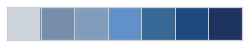

<Figure size 792x648 with 0 Axes>

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


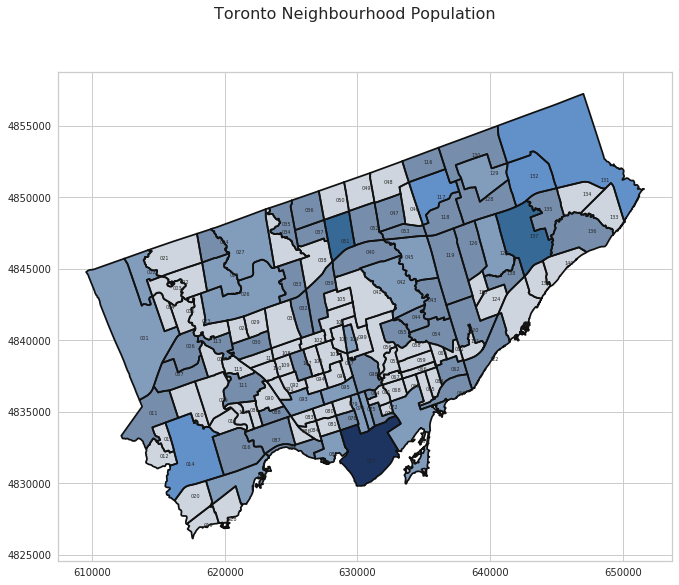

In [78]:
import numpy as np
def plot_comunas_data(sf, title, comunas, hood_id, data=None, color=None, print_id=False):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton, bins = calc_color(data, color)
    df = read_shapefile(sf)
    comuna_id = list(range(0,140))
    # for i in comunas:
    #     i = conv_comuna(i).upper()
    #     comuna_id.append(df[df.NOM_COMUNA == 
    #                         i.upper()].index.get_values()[0])
    plot_map_fill_multiples_ids_tone(sf, title, comuna_id, 
                                     print_id, 
                                     color_ton, 
                                     bins, hood_id,
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9));  
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton, 
                                     bins, hood_id,
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
            x = [i[0] for i in shape.shape.points[:]]
            y = [i[1] for i in shape.shape.points[:]]
            ax.plot(x, y, 'k')
            
    for id in comuna:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color_ton[comuna.index(id)])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            plt.text(x0, y0, hood_id[id], fontsize=5)
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

def calc_color(data, color=None):
        if color   == 1: 
          color_sq =  ['#ced5deff','#768eabff','#829cbcff', '#6290c8ff','#376996ff','#1f487eff','#1d3461ff']; colors = color_sq; # blue
        elif color == 2: 
          color_sq = ['#cd5402ff','#e25c02ff','#f96502ff','#ed4c02ff','#e13301ff','#d51a01ff','#c80000ff']; colors = color_sq; # red 
          # color_sq = ['#f8f9faff','#ced4daff','#adb5bdff','#495057ff','#41474eff','#2e3338ff','#121417ff']; colors = color_sq;# gray
        elif color == 3: 
          color_sq = ['#f8f9faff','#ced4daff','#adb5bdff','#495057ff','#41474eff','#2e3338ff','#121417ff']; colors = color_sq;# gray
        # elif color == 9: 
        #   color_sq = ['#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000']
        elif color == 4:
          color_sq = ['#b2a496ff','#9d8977ff','#886e58ff','#735238ff','#5e3719ff','#553217ff','#4d2d15ff'];colors = color_sq; # coffee
        else:     
          color_sq =  ['#ced5deff','#768eabff','#829cbcff', '#6290c8ff','#376996ff','#1f487eff','#1d3461ff']; colors = color_sq; # blue
        new_data, bins = pd.cut(data, 7, retbins=True, labels=list(range(7)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=7)
            sns.palplot(colors, 0.6);
            for i in range(7):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                       " => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2    3    4    5    6    7 ")    
        return color_ton, bins;
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

print_id = True # The shape id will be printed
color_pallete = 1 # blue
df = read_shapefile(sf)
nei_list= list(df['Neighbourh'])
pu= df['F2020_Popu']
comuna_id = list(range(0,140))
hood_id = list(df['Hood_ID'])
plot_comunas_data(sf, 'Toronto Neighbourhood Population', nei_list,hood_id, pu, color_pallete, print_id)

## show the population in different age group.

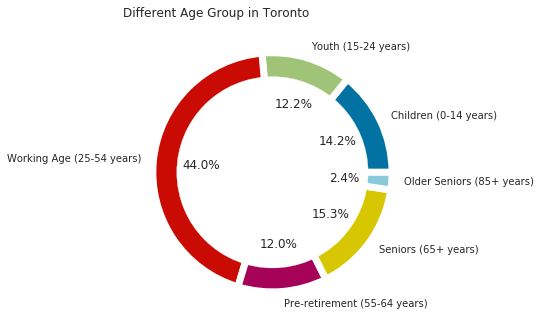

In [79]:
## pie chart for different age group 
age_data= nei_profile[9:15]
age_data.head()
pie_data= age_data[['Characteristic','City of Toronto']]
pie_data=pie_data.apply(lambda x: x.str.replace(',',''))

pie_data.head()
pie_data.shape


names = pie_data['Characteristic']
size = pie_data['City of Toronto']
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.8, color='white')

# Custom wedges
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },autopct="%.1f%%")
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title('Different Age Group in Toronto',loc='left')
plt.show()

## show the different between male and female population

In [80]:
# read in related data 
male_female= nei_profile[15:58]
male_female.reset_index(inplace=True)
male_female.head(20)

,index,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,15,16,Population,Age characteristics,Census Profile 98-316-X2016001,Male: 0 to 04 years,"69,895",660,575,360,...,355,620,1625,460,225,325,300,220,755,320
1,16,17,Population,Age characteristics,Census Profile 98-316-X2016001,Male: 05 to 09 years,"69,350",695,540,270,...,310,625,1705,400,180,350,305,220,685,315
2,17,18,Population,Age characteristics,Census Profile 98-316-X2016001,Male: 10 to 14 years,"64,945",660,460,225,...,265,610,1600,330,180,310,280,195,635,370
3,18,19,Population,Age characteristics,Census Profile 98-316-X2016001,Male: 15 to 19 years,"74,240",840,780,285,...,415,680,1815,275,160,260,255,145,900,485
4,19,20,Population,Age characteristics,Census Profile 98-316-X2016001,Male: 20 to 24 years,"97,415",1015,1000,355,...,705,705,2310,255,200,385,345,260,1615,500
5,20,21,Population,Age characteristics,Census Profile 98-316-X2016001,Male: 25 to 29 years,"113,905",1015,1045,355,...,790,655,2010,335,235,595,530,630,1545,465
6,21,22,Population,Age characteristics,Census Profile 98-316-X2016001,Male: 30 to 34 years,"108,895",835,820,410,...,780,570,1730,510,315,620,605,620,1105,425
7,22,23,Population,Age characteristics,Census Profile 98-316-X2016001,Male: 35 to 39 years,"94,070",680,625,455,...,555,590,1585,565,340,535,450,410,875,430
8,23,24,Population,Age characteristics,Census Profile 98-316-X2016001,Male: 40 to 44 years,"86,535",760,610,420,...,530,605,1585,545,295,425,395,365,775,395
9,24,25,Population,Age characteristics,Census Profile 98-316-X2016001,Male: 45 to 49 years,"90,860",890,760,440,...,470,745,1675,505,300,480,390,405,775,505


In [81]:
wrong_row= male_female.iloc[16,:]
df1= male_female[0:16]
df2= male_female[17:22]
frames = [df1, df2]
male_data= pd.concat(frames)
male_female
df3= male_female[22:24]
df3=df3.append(wrong_row)
df4= male_female[24:42]
frames= [df3,df4]
female_data= pd.concat(frames)
female_data.reset_index(inplace= True)
f_list= list(female_data['City of Toronto'])
m_list= list(male_data['City of Toronto'])
new_frame=pd.DataFrame(columns=['Age Group','Male', 'Female'])
new_frame['Male']=m_list
new_frame['Female']= f_list
age_group= male_data['Characteristic']
age_group_list=[]
for i in age_group:
  index= age_group[age_group == i].index[0]
  i= i.replace('Male:','').replace('to', '-').replace('years','').replace('04','4').replace('05','5').replace('09','9').replace('100  and over', '100>' )
  age_group_list.append(i)
new_frame['Age Group' ]= age_group_list
new_frame=new_frame.apply(lambda x: x.str.replace(',',''))
new_frame['Male']=new_frame['Male'].apply(lambda x:float(x) )
new_frame['Female']= new_frame['Female'].apply(lambda x:float(x) )
new_frame.head(20)

,Age Group,Male,Female
0,0 - 4,69895.0,66105.0
1,5 - 9,69350.0,65680.0
2,10 - 14,64945.0,62165.0
3,15 - 19,74240.0,71285.0
4,20 - 24,97415.0,97330.0
5,25 - 29,113905.0,119040.0
6,30 - 34,108895.0,115675.0
7,35 - 39,94070.0,102240.0
8,40 - 44,86535.0,95860.0
9,45 - 49,90860.0,100065.0


## Show the different between male and female population in each age group

Text(0, 0.5, 'Population')

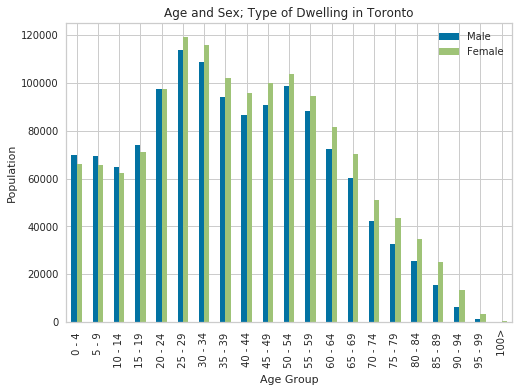

In [82]:
ax=new_frame.plot(kind="bar",title="Age and Sex; Type of Dwelling in Toronto",)
ax.set_xticklabels(new_frame['Age Group'])
ax.set_xlabel("Age Group")
ax.set_ylabel('Population')

# Crime rate:
## Create a map of Toronto to show crime rate in each neighbourhoods

In [83]:
df.columns.values.tolist() 

['OBJECTID',
 'Neighbourh',
 'Hood_ID',
 'F2020_Popu',
 'Assault_20',
 'Assault__1',
 'Assault__2',
 'Assault__3',
 'Assault__4',
 'Assault__5',
 'Assault__6',
 'Assault_Ra',
 'Assault__7',
 'Assault__8',
 'Assault__9',
 'Assault_10',
 'Assault_11',
 'Assault_12',
 'AutoTheft_',
 'AutoThef_1',
 'AutoThef_2',
 'AutoThef_3',
 'AutoThef_4',
 'AutoThef_5',
 'AutoThef_6',
 'AutoThef_7',
 'AutoThef_8',
 'AutoThef_9',
 'AutoThef10',
 'AutoThef11',
 'AutoThef12',
 'AutoThef13',
 'BreakAndEn',
 'BreakAnd_1',
 'BreakAnd_2',
 'BreakAnd_3',
 'BreakAnd_4',
 'BreakAnd_5',
 'BreakAnd_6',
 'BreakAnd_7',
 'BreakAnd_8',
 'BreakAnd_9',
 'BreakAnd10',
 'BreakAnd11',
 'BreakAnd12',
 'BreakAnd13',
 'Robbery_20',
 'Robbery__1',
 'Robbery__2',
 'Robbery__3',
 'Robbery__4',
 'Robbery__5',
 'Robbery__6',
 'Robbery_Ra',
 'RobberyRat',
 'Robbery__7',
 'Robbery__8',
 'Robbery__9',
 'Robbery_10',
 'Robbery_11',
 'TheftOver_',
 'TheftOve_1',
 'TheftOve_2',
 'TheftOve_3',
 'TheftOve_4',
 'TheftOve_5',
 'TheftOve_6',


In [84]:
new_data_frame=pd.DataFrame()
# new_data_frame= df [['Assault_AV', 'AutoThef_6', 'Breakand_6', 'Homicide_A', 'Robbery_AV', 'TheftOve_6' ]].mean()
new_data_frame['Neighbourh'] =df['Neighbourh']
new_data_frame['crimes']=(df['Assault__6']+ df['AutoThef_6']+df['BreakAnd_6']+df['Homicide_6']+df['Robbery__6']+df['TheftOve_6'])/6.0
crimes_number= list(new_data_frame['crimes'])
# print(new_data_frame.head())
# print(max(crimes_number))
# print(min(crimes_number))
new_data_frame['average_crime_percentage'] = list( map(lambda x: x/sum(crimes_number), crimes_number))
new_data_frame.head(10)

,Neighbourh,crimes,average_crime_percentage
0,Yonge-St.Clair,11.000000,0.001917
1,York University Heights,120.000000,0.020917
2,Lansing-Westgate,33.333333,0.005810
3,Yorkdale-Glen Park,63.833333,0.011127
4,Stonegate-Queensway,34.833333,0.006072
5,Tam O'Shanter-Sullivan,40.666667,0.007088
6,The Beaches,31.500000,0.005491
7,Thistletown-Beaumond Heights,20.500000,0.003573
8,Thorncliffe Park,27.166667,0.004735
9,Danforth East York,19.833333,0.003457


## The average of crime ratepercentage


1: 8 => 38 
2: 39 => 68 
3: 69 => 98 
4: 99 => 128 
5: 129 => 158 
6: 159 => 188 
7: 189 => 218 

   1   2    3    4    5    6    7 


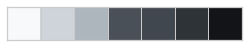

<Figure size 792x648 with 0 Axes>

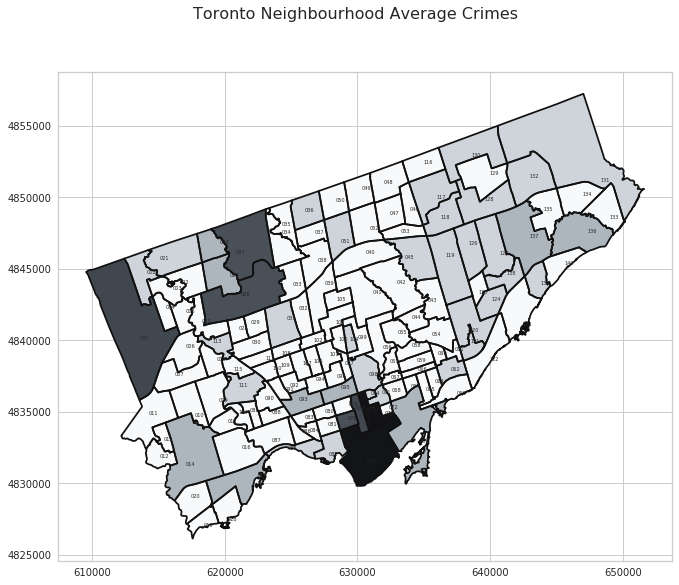

In [85]:
print_id = True # The shape id will be printed
color_pallete = 3 # 'Purples'
plot_comunas_data(sf, 'Toronto Neighbourhood Average Crimes', nei_list,hood_id, crimes_number, color_pallete, print_id)

In [86]:
average_income= pd.DataFrame(nei_profile.loc[2272,:])
average_income=average_income.transpose()
average_income.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
2272,2273,Income,Income sources,Catalogue no. 98-400-X2016122,Total income: Average amount ($),"52,268","30,414","31,825","47,709","112,766",...,"44,576","44,177","30,878","55,199","47,710","54,460","89,330","114,174","29,958","38,527"


# Income:
## Create a map of Toronto to show income in each neighbourhoods


1: 25706 => 66276 
2: 66277 => 106565 
3: 106566 => 146854 
4: 146855 => 187142 
5: 187143 => 227431 
6: 227432 => 267720 
7: 267721 => 308009 

   1   2    3    4    5    6    7 


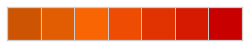

<Figure size 792x648 with 0 Axes>

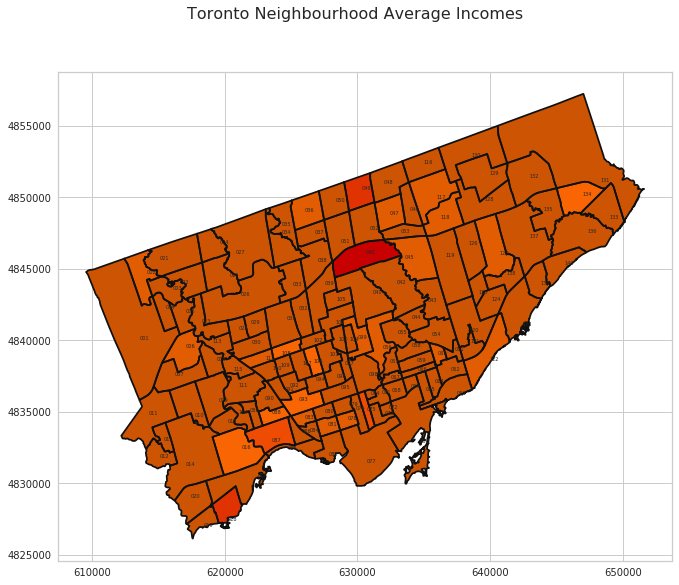

In [87]:
average_income= pd.DataFrame(nei_profile.loc[2272,:])
average_income=average_income.transpose()
# print(average_income.shape)
# print(average_income.columns)

for i in range(0,146):
  a= average_income.iloc[0,i]
  try:
    a=float(a.replace(",",""))
    average_income.iloc[0,i]=a
  except:
    pass


# print(average_income.head())
# print(a)
# average_income=average_income.astype('float', errors='ignore',inplace=True)

average_income.reset_index(inplace=True)
temp= []
temp2=[]
for i in range(6,147):
  value= average_income.iloc[0,i]
  temp2.append(float(value))
  temp.append(float(value))
total_income = sum(temp)
for i in range(6,147):
  average_income.iloc[0,i]= float(average_income.iloc[0,i])/total_income
  # temp2.append(float(average_income.iloc[0,i]))
average_income_grouped= average_income.transpose()
average_income_grouped.columns= ['income']


average_income_grouped.iloc[0:7].index
average_income_grouped.drop(average_income_grouped.iloc[0:7].index,inplace=True)
average_income_grouped.shape
average_income_list= list(average_income_grouped['income'])
print_id = True # The shape id will be printed
color_pallete = 2 # 'Purples'
plot_comunas_data(sf, 'Toronto Neighbourhood Average Incomes', nei_list,hood_id, temp2, color_pallete, print_id)

In [94]:
average_income_grouped.head(10)

,income
Agincourt North,0.00390571
Agincourt South-Malvern West,0.00408691
Alderwood,0.0061267
Annex,0.0144812
Banbury-Don Mills,0.00870123
Bathurst Manor,0.00589902
Bay Street Corridor,0.00725897
Bayview Village,0.00668224
Bayview Woods-Steeles,0.00606725
Bedford Park-Nortown,0.0158053


## Display Chinese population in each neighbourhood

In [95]:
ethnic= pd.DataFrame()
ethnic=nei_profile[1349:1609]
# print(ethnic[ethnic['Characteristic']==' Chinese'])
select_ethnics =  [ ethnic[ethnic['Characteristic']==' Chinese' ]]
Chinese_ethnics = pd.concat(select_ethnics )
Chinese_ethnics.drop(Chinese_ethnics.columns[0:4], axis=1, inplace=True)
Chinese_ethnics=Chinese_ethnics.apply(lambda x: x.str.replace(',',''))
Chinese_ethnics.drop(['City of Toronto', 'Characteristic'], axis=1, inplace=True)

Chinese_ethnics.shape


(1, 140)

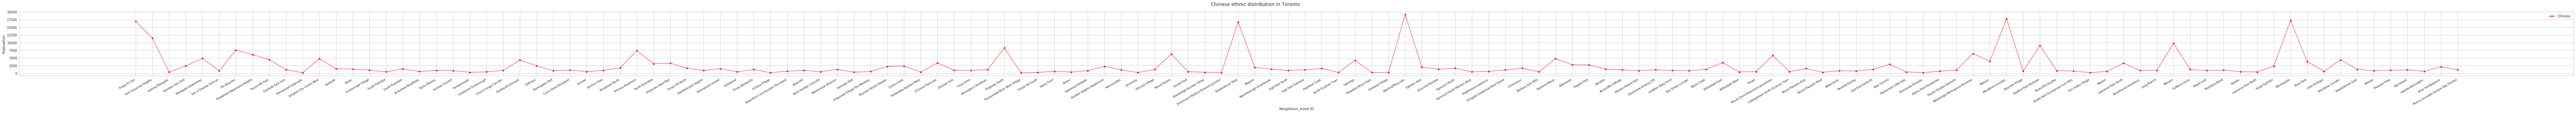

In [96]:
for i in range(0,1):
  for j in range(0,140):
    a= float(Chinese_ethnics.iloc[i,j])
    Chinese_ethnics.iloc[i,j]=a
# # for col in East_Asian.columns: 
# #     print(len(col))

# #     East_Asian[col] = East_Asian[col].astype('float', errors='ignore',inplace=True)




Chinese= list(Chinese_ethnics.iloc[0 ,:])
ethnic_plot_data= pd.DataFrame(columns=['Neighbours','Chinese'])
ethnic_plot_data['Neighbours']=nei_list
ethnic_plot_data['Chinese'] = Chinese
ethnic_plot_data.head(10)


fig = plt.figure(figsize=(140,4)) 

plt.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()
plt.plot( 'Neighbours', 'Chinese', data=ethnic_plot_data, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=1)
# show legend
plt.legend()
fig.suptitle('Chinese ethnic distribution in Toronto')
plt.xlabel('Neighbour_hood ID')
plt.ylabel('Popluation')
# show graph
plt.show() # click to zoom in 
#fig.savefig('fig4.jpg')

## get the venues from frousqaure API, develper information 

In [97]:
CLIENT_ID = 'QUDRUP4LNJLIKPKUEAVPELVPN5VHUMQYCUKD3INTW5ELNTQT' # your Foursquare ID
CLIENT_SECRET = 'GQM43H3EXOBPAHUU3DKELTDWNVL52UMPMTBRQCXIZRGMB5M4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 20 # A default Foursquare API limit value
radius= 5000
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    counter=0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        counter+=1
        # print(counter)
        # print(venues_list)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [98]:
# Toronto_venues = getNearbyVenues(names=df_Toronto['Neighborhood'],
#                                    latitudes=df_Toronto['Latitude'],
#                                    longitudes=df_Toronto['Longitude'])
# Toronto_venues.to_csv('Toronto_venues.csv')

In [99]:
Toronto_venues=pd.read_csv('Toronto_venues.csv')
Toronto_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 176 uniques categories.


In [100]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] =Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot['Neighborhood']
first_column = Toronto_onehot.pop('Neighborhood')
Toronto_onehot.insert(0, 'Neighborhood', first_column)
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()
Toronto_grouped.columns.values.tolist()

['Neighborhood',
 'Zoo Exhibit',
 'Afghan Restaurant',
 'African Restaurant',
 'Airport',
 'American Restaurant',
 'Art Gallery',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Dealership',
 'Automotive Shop',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bar',
 'Basketball Stadium',
 'Beach',
 'Beer Bar',
 'Beer Store',
 'Bike Shop',
 'Bistro',
 'Bookstore',
 'Botanical Garden',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bridge',
 'Bubble Tea Shop',
 'Burger Joint',
 'Burrito Place',
 'Butcher',
 'Café',
 'Campground',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Castle',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Climbing Gym',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'Comedy Club',
 'Comic Shop',
 'Concert Hall',
 'Convenience Store',
 'Cosmetics Shop',
 'Creperie',
 'Dance Studio',
 'Deli / Bodega',
 'Department Store',
 'Dessert Shop',
 'Diner',
 'Discount Store',
 'Dog Run',
 'Doner Restaurant',
 'Eastern European Restaurant',
 'E

## See the popularity of Chinese restaurant and competitors in each neighborhood.

In [101]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()

key_words=['Asian Restaurant', 'Doner Restaurant', 'Chinese Restaurant',  'Hakka Restaurant', 'Cantonese Restaurant', 'Hotpot Restaurant','Szechuan Restaurant','Tibetan Restaurant','Xinjiang Restaurant','Neighborhood']

for i in Toronto_grouped.columns:
  if i not in key_words:
    Toronto_grouped.drop(i,axis=1,inplace=True)


# manhattan_grouped.head()
Toronto_grouped.head()

,Neighborhood,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant
0,Agincourt,0.05,0.05,0.05,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.00,0.00,0.00,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.00,0.00,0.00,0.0,0.0,0.0,0.0
3,Bayview Village,0.00,0.00,0.00,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.00,0.00,0.00,0.0,0.0,0.0,0.0


## show top 7 filtered restaurants in each neighbourhood.

In [102]:
num_top_venues = 7

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
print(hood)
temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)

----Agincourt----
----Alderwood, Long Branch----
----Bathurst Manor, Wilson Heights, Downsview North----
----Bayview Village----
----Bedford Park, Lawrence Manor East----
----Berczy Park----
----Birch Cliff, Cliffside West----
----Brockton, Parkdale Village, Exhibition Place----
----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
----Caledonia-Fairbanks----
----Cedarbrae----
----Central Bay Street----
----Christie----
----Church and Wellesley----
----Clairville, Humberwood, Woodbine Downs, West Humber, Kipling Heights, Rexdale, Elms, Tandridge, Old Rexdale----
----Clarks Corners, Tam O'Shanter, Sullivan----
----Cliffside, Cliffcrest, Scarborough Village West----
----Commerce Court, Victoria Hotel----
----Davisville----
----Davisville North----
----Del Ray, Mount Dennis, Keelsdale and Silverthorn----
----Don Mills North----
----Don Mills South----
----Dorset Park, Wexford Heights, Scarborough Town Centre----
----Downsview Ce

,venue,freq
0,Asian Restaurant,0.0
1,Cantonese Restaurant,0.0
2,Chinese Restaurant,0.0
3,Doner Restaurant,0.0
4,Hakka Restaurant,0.0
5,Szechuan Restaurant,0.0
6,Xinjiang Restaurant,0.0


In [103]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [104]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Agincourt,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant,Xinjiang Restaurant,Szechuan Restaurant,Hakka Restaurant,Doner Restaurant
1,"Alderwood, Long Branch",Xinjiang Restaurant,Szechuan Restaurant,Hakka Restaurant,Doner Restaurant,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Xinjiang Restaurant,Szechuan Restaurant,Hakka Restaurant,Doner Restaurant,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant
3,Bayview Village,Xinjiang Restaurant,Szechuan Restaurant,Hakka Restaurant,Doner Restaurant,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant
4,"Bedford Park, Lawrence Manor East",Xinjiang Restaurant,Szechuan Restaurant,Hakka Restaurant,Doner Restaurant,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant
5,Berczy Park,Xinjiang Restaurant,Szechuan Restaurant,Hakka Restaurant,Doner Restaurant,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant
6,"Birch Cliff, Cliffside West",Xinjiang Restaurant,Szechuan Restaurant,Hakka Restaurant,Doner Restaurant,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant
7,"Brockton, Parkdale Village, Exhibition Place",Asian Restaurant,Xinjiang Restaurant,Szechuan Restaurant,Hakka Restaurant,Doner Restaurant,Chinese Restaurant,Cantonese Restaurant
8,"CN Tower, King and Spadina, Railway Lands, Har...",Xinjiang Restaurant,Szechuan Restaurant,Hakka Restaurant,Doner Restaurant,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant
9,Caledonia-Fairbanks,Xinjiang Restaurant,Szechuan Restaurant,Hakka Restaurant,Doner Restaurant,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant


## Show Chinese population ratio in each neighbourhood

In [105]:
ethnic= pd.DataFrame()
ethnic=nei_profile[1349:1609]
# print(ethnic[ethnic['Characteristic']==' Chinese'])
select_ethnics =  [ ethnic[ethnic['Characteristic']==' Chinese' ]]
Chinese = pd.concat(select_ethnics )
Chinese.drop(Chinese.columns[0:4], axis=1, inplace=True)
Chinese=Chinese.apply(lambda x: x.str.replace(',',''))

# percentage= []

Chinese.iloc[0,141]
for i in range(0, Chinese.shape[0]):
  total= Chinese.iloc[i,1]
  print(total)
  for n in range(2,142):
    Chinese.iloc[i,n]=float(Chinese.iloc[i,n]) / float(total)

Chinese_grouped = Chinese.transpose()
Chinese_grouped = Chinese_grouped.drop('City of Toronto')
Chinese_grouped.columns = Chinese_grouped.iloc[0,0:]
Chinese_grouped = Chinese_grouped.drop('Characteristic')
Chinese_grouped[[' Chinese']]

332830


Characteristic,Chinese
Agincourt North,0.0509269
Agincourt South-Malvern West,0.034417
Alderwood,0.00126191
Annex,0.00721089
Banbury-Don Mills,0.014572
Bathurst Manor,0.00247874
Bay Street Corridor,0.0227894
Bayview Village,0.0182225
Bayview Woods-Steeles,0.0134603
Bedford Park-Nortown,0.00356038


## Show incomes ratio in each neighbourhood

In [106]:
average_income= pd.DataFrame(nei_profile.loc[2272,:])
average_income=average_income.transpose()
for i in range(0,146):
  a= average_income.iloc[0,i]
  try:
    a=float(a.replace(",",""))
    average_income.iloc[0,i]=a
  except:
    pass
# average_income=average_income.apply(lambda x: x.str.replace(',',''))
average_income.reset_index(inplace=True)
temp= []
for i in range(6,147):
  value= average_income.iloc[0,i]
  temp.append(float(value))
total_income = sum(temp)
for i in range(6,147):
  average_income.iloc[0,i]= float(average_income.iloc[0,i])/total_income

average_income_grouped= average_income.transpose()
average_income_grouped.columns= ['income']


average_income_grouped.iloc[0:7].index
average_income_grouped.drop(average_income_grouped.iloc[0:7].index,inplace=True)
average_income_grouped.shape
print(average_income_grouped.head())

average_income_list= list(average_income_grouped['income'])


                                  income
Agincourt North               0.00390571
Agincourt South-Malvern West  0.00408691
Alderwood                      0.0061267
Annex                          0.0144812
Banbury-Don Mills             0.00870123


# Merge all features into one data frame

In [107]:

Chinese_grouped[[' Chinese']]
Chinese= []
for i in range(0,103):
  Chinese.append(Chinese_grouped.iloc[i,0])

Toronto_grouped['Population']=pu
Toronto_grouped['Chinese'] = Chinese
Toronto_grouped.head()
income_lst= []
for i in range(0,103):
  income_lst.append(average_income_grouped.iloc[i,0])

Toronto_grouped['income']= income_lst
Toronto_grouped['crime']=new_data_frame['average_crime_percentage']
Toronto_grouped.head()


,Neighborhood,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
0,Agincourt,0.05,0.05,0.05,0.0,0.0,0.0,0.0,14083,0.050927,0.003906,0.001917
1,"Alderwood, Long Branch",0.00,0.00,0.00,0.0,0.0,0.0,0.0,30277,0.034417,0.004087,0.020917
2,"Bathurst Manor, Wilson Heights, Downsview North",0.00,0.00,0.00,0.0,0.0,0.0,0.0,18146,0.001262,0.006127,0.005810
3,Bayview Village,0.00,0.00,0.00,0.0,0.0,0.0,0.0,17560,0.007211,0.014481,0.011127
4,"Bedford Park, Lawrence Manor East",0.00,0.00,0.00,0.0,0.0,0.0,0.0,27410,0.014572,0.008701,0.006072


# Kmean Clustering to cluster neighbourhoods

# Find the optimal K value
## apply Silhouetter Score to find the ideal number of clusters.

In [108]:
manhattan_grouped_clustering = Toronto_grouped.drop('Neighborhood',axis=1)
X = manhattan_grouped_clustering
X = np.nan_to_num(X)
Clus_dataSet = MinMaxScaler().fit_transform(X)
Clus_dataSet
X

array([[0.05      , 0.05      , 0.05      , ..., 0.0509269 , 0.00390571,
        0.00191738],
       [0.        , 0.        , 0.        , ..., 0.03441697, 0.00408691,
        0.02091686],
       [0.        , 0.        , 0.        , ..., 0.00126191, 0.0061267 ,
        0.00581024],
       ...,
       [0.05      , 0.        , 0.        , ..., 0.00459694, 0.00444289,
        0.00339899],
       [0.        , 0.        , 0.        , ..., 0.00100652, 0.0044199 ,
        0.01057463],
       [0.        , 0.        , 0.        , ..., 0.00247874, 0.0043738 ,
        0.00290512]])

27


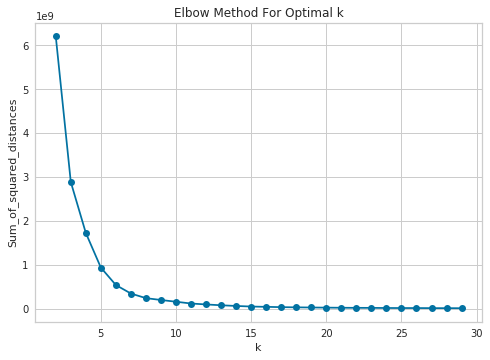

In [109]:
Sum_of_squared_distances = []
K = range(2,30)
for k in K:
    # print(k)
    km = KMeans(n_clusters=k,random_state=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
print(Sum_of_squared_distances.index(min(Sum_of_squared_distances)))
Sum_of_squared_distances
a=plt.plot(K, Sum_of_squared_distances, marker='o')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
# a.savefig('elbow.pdf')

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c6251c828>,
         estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0),
         k=None, locate_elbow=True, metric='distortion', timings=True)

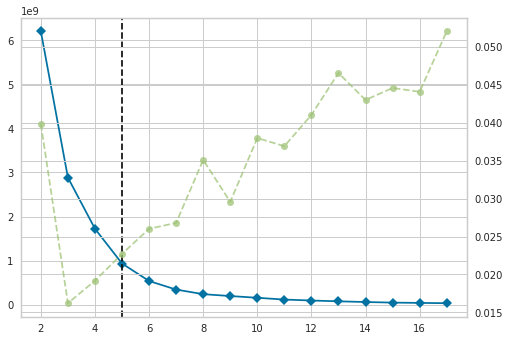

In [110]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans(random_state=10)
visualizer = KElbowVisualizer(model, k=(2,18))
visualizer.fit(X)
visualizer

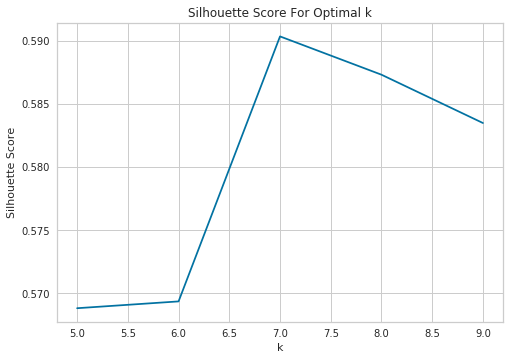

2
0.5903467289255038


In [111]:
from sklearn import datasets
from sklearn.cluster import KMeans
import sklearn
#

#
# km = KMeans(n_clusters=3, random_state=0)
# #
# # Fit the KMeans model
# #
# km.fit_predict(Clus_dataSet)
# #
# # Calculate Silhoutte Score
# #
# score = sklearn.metrics.silhouette_score(Clus_dataSet, km.labels_, metric='euclidean')

# print('Silhouetter Score: %.3f' % score)

K = range(5,10)
scorels= []
for k in K:
    # print(k)
    km = KMeans(n_clusters=k,random_state=10)
    km = km.fit(X)
    # print(k)
    score = sklearn.metrics.silhouette_score(X, km.labels_, metric='euclidean')
    # print(score)
    scorels.append(score)

b=plt.plot(K, scorels, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()
print(scorels.index(max(scorels)))
print(max(scorels))

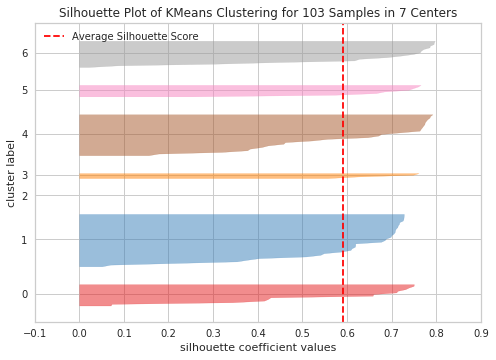

In [112]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
model = KMeans(7)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()

## The optimal K can be set to 7. 

In [113]:
km = KMeans(n_clusters=7, random_state=0)

km.fit_predict(Clus_dataSet)
klabels = km.labels_
print(klabels)
len(klabels)

[5 0 1 1 1 1 1 1 1 1 4 0 1 1 3 3 4 1 1 1 1 5 0 4 1 1 1 1 1 1 1 1 3 1 0 1 1
 1 1 6 0 0 5 3 2 1 1 3 4 1 2 0 1 1 1 1 3 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 3 1
 1 4 2 1 1 3 1 1 1 0 1 1 1 1 0 1 1 0 1 3 3 0 1 0 0 4 1 0 1]


103

In [114]:
nei_name=Toronto_grouped['Neighborhood']
neighborhoods_lables= pd.DataFrame()
neighborhoods_lables= pd.DataFrame(
    {'Neighborhood': nei_name,
     'klabels': klabels,})
neighborhoods_lables.head(15)

,Neighborhood,klabels
0,Agincourt,5
1,"Alderwood, Long Branch",0
2,"Bathurst Manor, Wilson Heights, Downsview North",1
3,Bayview Village,1
4,"Bedford Park, Lawrence Manor East",1
5,Berczy Park,1
6,"Birch Cliff, Cliffside West",1
7,"Brockton, Parkdale Village, Exhibition Place",1
8,"CN Tower, King and Spadina, Railway Lands, Har...",1
9,Caledonia-Fairbanks,1


In [115]:
# X=Clus_dataSet
af = AffinityPropagation(preference=None).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
# af = AffinityPropagation.fit(data_transformed)
# cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_
print(max(labels))
print(labels)
cluster_centers_indices

7
[2 0 3 3 0 0 7 5 7 3 2 1 5 5 3 7 0 3 3 2 3 2 6 0 3 7 2 2 2 2 2 2 2 2 0 2 5
 3 3 4 0 6 0 3 7 2 3 2 3 5 2 7 5 5 2 7 6 5 2 3 5 3 2 0 3 6 7 6 5 7 7 2 3 2
 7 7 0 7 5 0 0 7 3 1 0 3 2 2 0 7 2 6 5 0 7 1 3 1 6 2 3 6 5]


array([ 5, 11, 33, 37, 39, 49, 67, 74])

## Create a map of Toronto with each cluster of neighborhoods superimposed on top.

In [116]:
# neighborhoods_lables['alabels']=labels
neighborhoods_lables.head(20)
temp_df=Toronto_grouped.iloc[:,1:]
temp_df.head()
# Toronto_grouped.drop('klables',axis=1,inplace=True)
Toronto_grouped.insert(1,'klables',klabels)
Toronto_grouped.head(20)

,Neighborhood,klables,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
0,Agincourt,5,0.05,0.05,0.05,0.0,0.0,0.0,0.00,14083,0.050927,0.003906,0.001917
1,"Alderwood, Long Branch",0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30277,0.034417,0.004087,0.020917
2,"Bathurst Manor, Wilson Heights, Downsview North",1,0.00,0.00,0.00,0.0,0.0,0.0,0.00,18146,0.001262,0.006127,0.005810
3,Bayview Village,1,0.00,0.00,0.00,0.0,0.0,0.0,0.00,17560,0.007211,0.014481,0.011127
4,"Bedford Park, Lawrence Manor East",1,0.00,0.00,0.00,0.0,0.0,0.0,0.00,27410,0.014572,0.008701,0.006072
5,Berczy Park,1,0.00,0.00,0.00,0.0,0.0,0.0,0.00,29970,0.002479,0.005899,0.007088
6,"Birch Cliff, Cliffside West",1,0.00,0.00,0.00,0.0,0.0,0.0,0.00,23364,0.022789,0.007259,0.005491
7,"Brockton, Parkdale Village, Exhibition Place",1,0.05,0.00,0.00,0.0,0.0,0.0,0.00,10948,0.018223,0.006682,0.003573
8,"CN Tower, King and Spadina, Railway Lands, Har...",1,0.00,0.00,0.00,0.0,0.0,0.0,0.00,23518,0.013460,0.006067,0.004735
9,Caledonia-Fairbanks,1,0.00,0.00,0.00,0.0,0.0,0.0,0.00,18427,0.003560,0.015805,0.003457


In [117]:
toronto_merged = df_Toronto

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(Toronto_grouped.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(10) # check the last columns!

,Borough,Neighborhood,PostalCode,Latitude,Longitude,klables,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
0,North York,Parkwoods,M3A,43.753259,-79.329656,0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,37931,0.005739,0.009294,0.010023
1,North York,Victoria Village,M4A,43.725882,-79.315572,0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,38981,0.003425,0.005111,0.019726
2,Downtown Toronto,"Regent Park, Harbourfront",M5A,43.654260,-79.360636,1,0.0,0.00,0.00,0.0,0.0,0.0,0.0,7130,0.004176,0.014348,0.002324
3,North York,"Lawrence Manor, Lawrence Heights",M6A,43.718518,-79.464763,0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,21196,0.003590,0.005262,0.020888
4,Queen's Park,Ontario Provincial Government,M7A,43.662301,-79.389494,1,0.0,0.00,0.00,0.0,0.0,0.0,0.0,17619,0.001007,0.018575,0.002934
5,Etobicoke,Islington Avenue,M9A,43.667856,-79.532242,3,0.0,0.00,0.05,0.0,0.0,0.0,0.0,12050,0.001262,0.006832,0.004067
6,Scarborough,"Malvern, Rouge",M1B,43.806686,-79.194353,1,0.0,0.00,0.00,0.0,0.0,0.0,0.0,22545,0.001968,0.003792,0.004358
7,North York,Don Mills North,M3B,43.745906,-79.352188,5,0.0,0.05,0.00,0.0,0.0,0.0,0.0,14672,0.001352,0.021195,0.001975
8,East York,"Parkview Hill, Woodbine Gardens",M4B,43.706397,-79.309937,0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,26115,0.050311,0.004087,0.008919
9,Downtown Toronto,"Garden District, Ryerson",M5B,43.657162,-79.378937,1,0.0,0.00,0.00,0.0,0.0,0.0,0.0,10679,0.001412,0.013041,0.001569


In [118]:
# create map

kclusters = 7
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['klables']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Evaluate each cluster of neighbourhoods

# Cluster 0

In [149]:
from IPython.display import display
Lable_0 = Toronto_grouped[Toronto_grouped['klables'] ==0]
print(Lable_0.shape)
Lable_0.head(17)

(17, 13)


,Neighborhood,klables,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
1,"Alderwood, Long Branch",0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,30277,0.034417,0.004087,0.020917
11,Central Bay Street,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,51481,0.014317,0.004271,0.015571
22,Don Mills South,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,39279,0.002929,0.006940,0.035297
34,"First Canadian Place, Underground city",0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,33031,0.002764,0.005212,0.015165
40,"Harbourfront East, Union Station, Toronto Islands",0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,29669,0.002914,0.006036,0.014351
41,"High Park, The Junction South",0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,37133,0.001427,0.004913,0.025681
51,"Lawrence Manor, Lawrence Heights",0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,21196,0.003590,0.005262,0.020888
65,"Parkdale, Roncesvalles",0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,40355,0.000661,0.009841,0.015310
66,"Parkview Hill, Woodbine Gardens",0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,26115,0.050311,0.004087,0.008919
67,Parkwoods,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,37931,0.005739,0.009294,0.010023


## This cluster has high population but it has no interest in Chinese restaurant.

# Cluster 1

In [150]:
Lable_1= Toronto_grouped[Toronto_grouped['klables'] ==1 ]
print(Lable_1.shape)
Lable_1.head(63)

(63, 13)


,Neighborhood,klables,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
2,"Bathurst Manor, Wilson Heights, Downsview North",1,0.00,0.0,0.0,0.00,0.0,0.0,0.0,18146,0.001262,0.006127,0.005810
3,Bayview Village,1,0.00,0.0,0.0,0.00,0.0,0.0,0.0,17560,0.007211,0.014481,0.011127
4,"Bedford Park, Lawrence Manor East",1,0.00,0.0,0.0,0.00,0.0,0.0,0.0,27410,0.014572,0.008701,0.006072
5,Berczy Park,1,0.00,0.0,0.0,0.00,0.0,0.0,0.0,29970,0.002479,0.005899,0.007088
6,"Birch Cliff, Cliffside West",1,0.00,0.0,0.0,0.00,0.0,0.0,0.0,23364,0.022789,0.007259,0.005491
7,"Brockton, Parkdale Village, Exhibition Place",1,0.05,0.0,0.0,0.00,0.0,0.0,0.0,10948,0.018223,0.006682,0.003573
8,"CN Tower, King and Spadina, Railway Lands, Har...",1,0.00,0.0,0.0,0.00,0.0,0.0,0.0,23518,0.013460,0.006067,0.004735
9,Caledonia-Fairbanks,1,0.00,0.0,0.0,0.00,0.0,0.0,0.0,18427,0.003560,0.015805,0.003457
12,Christie,1,0.05,0.0,0.0,0.00,0.0,0.0,0.0,10353,0.004477,0.006981,0.003864
13,Church and Wellesley,1,0.00,0.0,0.0,0.00,0.0,0.0,0.0,10756,0.004131,0.003337,0.003167


## This cluster has no interest in Chinese restaurant.

# Cluster 2

In [151]:
Lable_2= Toronto_grouped[Toronto_grouped['klables'] ==2 ]
print(Lable_2.shape)
Lable_2.head(3)

(3, 13)


,Neighborhood,klables,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
44,"Humberlea, Emery",2,0.15,0.0,0.05,0.0,0.0,0.0,0.0,23318,0.001683,0.026264,0.005316
50,"Kingsview Village, St. Phillips, Martin Grove ...",2,0.10,0.0,0.10,0.0,0.0,0.0,0.0,12334,0.002764,0.009144,0.003602
76,"South Steeles, Silverstone, Humbergate, Jamest...",2,0.15,0.0,0.10,0.0,0.0,0.0,0.0,29864,0.057507,0.003607,0.011330


## This cluster has high interest on Chinese restaurant but also has some competitors, we can choose some neighborhoods to open a Chinese restaurant.

# Cluster 3

In [152]:
Lable_3= Toronto_grouped[Toronto_grouped['klables'] ==3 ]
print(Lable_3.shape)
Lable_3.head(10)

(10, 13)


,Neighborhood,klables,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
14,"Clairville, Humberwood, Woodbine Downs, West H...",3,0.05,0.0,0.05,0.0,0.00,0.0,0.0,18116,0.003110,0.006230,0.007350
15,"Clarks Corners, Tam O'Shanter, Sullivan",3,0.05,0.0,0.05,0.0,0.00,0.0,0.0,24212,0.001352,0.004465,0.010749
32,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",3,0.00,0.0,0.05,0.0,0.00,0.0,0.0,13072,0.009960,0.005103,0.003050
43,Humber Summit,3,0.05,0.0,0.05,0.0,0.00,0.0,0.0,18407,0.001157,0.010928,0.007931
47,Islington Avenue,3,0.00,0.0,0.05,0.0,0.00,0.0,0.0,12050,0.001262,0.006832,0.004067
56,"Milliken, Agincourt North, Steeles East, L'Amo...",3,0.00,0.0,0.10,0.0,0.05,0.0,0.0,34680,0.001172,0.008382,0.017227
72,"Rouge Hill, Port Union, Highland Creek",3,0.00,0.0,0.05,0.0,0.00,0.0,0.0,20595,0.000751,0.006085,0.010662
79,"Steeles West, L'Amoreaux West",3,0.00,0.0,0.05,0.0,0.00,0.0,0.0,31618,0.004957,0.007566,0.004822
93,Westmount,3,0.10,0.0,0.05,0.0,0.00,0.0,0.0,32790,0.002524,0.006847,0.026059
94,Weston,3,0.05,0.0,0.05,0.0,0.00,0.0,0.0,23206,0.003786,0.007457,0.012463


## This cluster has a certain level of interest on Chinese restaurant and less competitors, we can choose some neighborhoods to open a Chinese restaurant.

# Cluster 4

In [153]:
Lable_4= Toronto_grouped[Toronto_grouped['klables'] ==4 ]
print(Lable_4.shape)
Lable_4.head(6)

(6, 13)


,Neighborhood,klables,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
10,Cedarbrae,4,0.00,0.0,0.00,0.0,0.0,0.0,0.05,15854,0.000511,0.004344,0.003660
16,"Cliffside, Cliffcrest, Scarborough Village West",4,0.00,0.0,0.00,0.0,0.0,0.0,0.05,30225,0.004342,0.039554,0.013102
23,"Dorset Park, Wexford Heights, Scarborough Town...",4,0.05,0.0,0.05,0.0,0.0,0.0,0.05,29302,0.012935,0.006881,0.009587
48,"Kennedy Park, Ionview, East Birchmount Park",4,0.05,0.0,0.00,0.0,0.0,0.0,0.05,20156,0.010110,0.004669,0.005578
75,Scarborough Village,4,0.05,0.0,0.00,0.0,0.0,0.0,0.05,22588,0.000811,0.008010,0.005781
99,Woburn,4,0.00,0.0,0.00,0.0,0.0,0.0,0.05,12655,0.001637,0.012720,0.007059


## This cluster has high interest on Xinjiang restaurant but has less interest on Chinese Restaurant, we do not recommend to open Chinese restaurant in these neighborhoods.

# Cluster 5

In [154]:
Lable_5= Toronto_grouped[Toronto_grouped['klables'] ==5 ]
print(Lable_5.shape)
Lable_5.head(3)

(3, 13)


,Neighborhood,klables,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
0,Agincourt,5,0.05,0.05,0.05,0.0,0.0,0.00,0.0,14083,0.050927,0.003906,0.001917
21,Don Mills North,5,0.00,0.05,0.00,0.0,0.0,0.00,0.0,14672,0.001352,0.021195,0.001975
42,Hillcrest Village,5,0.00,0.05,0.05,0.0,0.0,0.05,0.0,28248,0.003861,0.003680,0.005142


## This cluster has a certain level of interest on Chinese restaurant but also has some competitors.

# Cluster 6

In [155]:
Lable_6= Toronto_grouped[Toronto_grouped['klables'] ==6 ]
print(Lable_6.shape)
Lable_6.head(1)

(1, 13)


,Neighborhood,klables,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
39,"Guildwood, Morningside, West Hill",6,0.0,0.0,0.0,0.0,0.0,0.0,0.05,87808,0.002028,0.006181,0.038202


## This cluster has very high population but has no interest in Chinese restaurant and has high crime rate.

In [156]:
Toronto_grouped.head()

,Neighborhood,klables,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
0,Agincourt,5,0.05,0.05,0.05,0.0,0.0,0.0,0.0,14083,0.050927,0.003906,0.001917
1,"Alderwood, Long Branch",0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,30277,0.034417,0.004087,0.020917
2,"Bathurst Manor, Wilson Heights, Downsview North",1,0.00,0.00,0.00,0.0,0.0,0.0,0.0,18146,0.001262,0.006127,0.005810
3,Bayview Village,1,0.00,0.00,0.00,0.0,0.0,0.0,0.0,17560,0.007211,0.014481,0.011127
4,"Bedford Park, Lawrence Manor East",1,0.00,0.00,0.00,0.0,0.0,0.0,0.0,27410,0.014572,0.008701,0.006072


# Conclusion:
## By comparing the popularity of Chinese restaurants, population, proportion of Chinese, income, competitors and crime rate together, we have tallied the scores of the neighborhoods in both cluster 2 and cluster 3 in below table. We selected top 3 neighborhoods as recommended locations to open a Chinese restaurant.
<div align=center><img src = "https://raw.githubusercontent.com/shenwl1014/IBM-Data-Science-Capstone-Project/main/Scores%20of%20neighborhoods.png" width = 1300 > 

In [157]:
Recommended_location = Toronto_grouped.iloc[[56,76,79],[0]]
Recommended_location = Recommended_location.join(toronto_merged.set_index('Neighborhood'), on='Neighborhood')
Recommended_location

,Neighborhood,Borough,PostalCode,Latitude,Longitude,klables,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Doner Restaurant,Hakka Restaurant,Szechuan Restaurant,Xinjiang Restaurant,Population,Chinese,income,crime
56,"Milliken, Agincourt North, Steeles East, L'Amo...",Scarborough,M1V,43.815252,-79.284577,3,0.00,0.0,0.10,0.0,0.05,0.0,0.0,34680,0.001172,0.008382,0.017227
76,"South Steeles, Silverstone, Humbergate, Jamest...",Etobicoke,M9V,43.739416,-79.588437,2,0.15,0.0,0.10,0.0,0.00,0.0,0.0,29864,0.057507,0.003607,0.011330
79,"Steeles West, L'Amoreaux West",Scarborough,M1W,43.799525,-79.318389,3,0.00,0.0,0.05,0.0,0.00,0.0,0.0,31618,0.004957,0.007566,0.004822


In [158]:
Recommended_location_map = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, borough, neighborhood in zip(Recommended_location['Latitude'], Recommended_location['Longitude'], Recommended_location['Borough'], Recommended_location['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Recommended_location_map)
print('*********************************************************************************************')     
print('In conclusion, the recommended locations to open a Chinese retaurant are marked in below map!')
print('*********************************************************************************************') 
Recommended_location_map

*********************************************************************************************
In conclusion, the recommended locations to open a Chinese retaurant are marked in below map!
*********************************************************************************************
